# Assignment2

Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from anonymizedf.anonymizedf import anonymize

Import the data

In [2]:
df = pd.read_csv(r"athletes.csv")

/var/folders/lt/x1xcmh9n5xz2fgqn5y9_3kf40000gn/T/ipykernel_29460/3087902215.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"athletes.csv")


Remove rows with more than 1 NaN and columns NaNs

In [3]:
df=df.dropna(thresh=27)
df = df.dropna(axis=1, thresh=len(df))

Display

In [4]:
display(df)

,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,24.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,31.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,37.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,44.0,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,31.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,56.0,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,54.0,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,36.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,26.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


## 3.1 Anonymisation: Bare Bones

Text(0.5, 1.0, 'Cardinality')

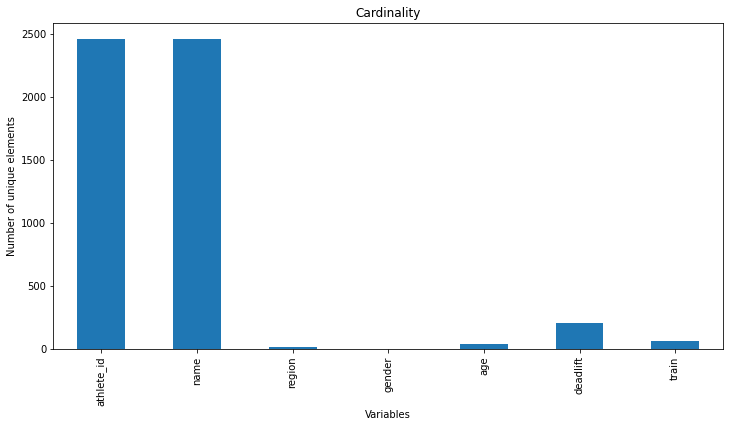

In [5]:
df.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique elements')
plt.xlabel('Variables')
plt.title('Cardinality')

Quassi Idetifiers Combination values uniqueness

In [6]:
display(df.groupby(['age','region','gender']).size().reset_index(name='count'))

,age,region,gender,count
0,14.0,South Central,Male,1
1,17.0,Australia,Male,1
2,17.0,North Central,Male,1
3,17.0,North East,Male,1
4,17.0,North West,Male,1
...,...,...,...,...
740,55.0,South West,Male,1
741,56.0,Canada West,Male,1
742,56.0,Central East,Male,1
743,56.0,South East,Male,1


In [18]:
def k_anonymity(data, k, suppression_order):
    anonymized_data = data.copy()

    for column in suppression_order:
        # Group by quasi-identifiers and count records in each group
        grouped_data = anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count')

        # Identify groups that don't meet k-anonymity and suppress values selectively if needed
        for index, row in grouped_data.iterrows():
            if row['count'] < k:
                if grouped_data[column].nunique() > 1:
                    # Create a mask for the specific column based on quasi-identifier values
                    mask = (anonymized_data['region'] == row['region']) & \
                        (anonymized_data['age'] == row['age']) & \
                        (anonymized_data['gender'] == row['gender'])
                    # Apply the '*' suppression to the specific column where the row matches
                    anonymized_data.loc[mask, column] = '*'

    return anonymized_data

suppression_order = ['age', 'gender', 'region']

anonymized_data = k_anonymity(df, k=5, suppression_order=suppression_order)

display(anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count'))
print("Anonymized:")
display(anonymized_data)

,region,age,gender,count
0,*,*,*,6
1,Africa,*,Female,5
2,Africa,*,Male,15
3,Asia,*,Male,22
4,Australia,23.0,Male,6
...,...,...,...,...
213,Southern California,35.0,Male,6
214,Southern California,36.0,Male,9
215,Southern California,37.0,Male,6
216,Southern California,*,Female,43


Anonymized:


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,24.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,31.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,37.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,*,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,31.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,*,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,*,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,*,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,*,355.0,I workout mostly at a CrossFit Affiliate|I hav...


## 3.1 and 3.2 Anonymising your dataset

### Generalize numeric columns

In [32]:
def k_anonymity_suppression_generalization(data, k, suppression_order):
    anonymized_data = data.copy()

    for column in suppression_order:
        # Group by quasi-identifiers and count records in each group
        grouped_data = anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count')

        # Identify groups that don't meet k-anonymity
        groups_to_anonymize = grouped_data[grouped_data['count'] < k][['region', 'age', 'gender']]

        # Iterate over groups and suppress or generalize values in the original dataset
        for index, row in groups_to_anonymize.iterrows():
            mask = (anonymized_data['region'] == row['region']) & \
                   (anonymized_data['age'] == row['age']) & \
                   (anonymized_data['gender'] == row['gender'])

            if mask.any():
                # If the group size is less than k, apply suppression or generalization
                if len(anonymized_data[mask]) < k:
                    # Generalize numerical values by rounding to the nearest integer
                    if anonymized_data[column].dtype == 'int64' or anonymized_data[column].dtype == 'float64':
                        anonymized_data[column] = anonymized_data[column] // 10 * 10
                    # Suppression for non-numerical values
                    else:
                        anonymized_data.loc[mask, column] = '*'

    return anonymized_data


# Specify the order in which columns should be suppressed or generalized
suppression_order = ['age', 'gender', 'region']

# Apply k_anonymity_suppression_generalization_sequential function
k_anonymized_data = k_anonymity_suppression_generalization(df, k=3, suppression_order=suppression_order)


display(k_anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count'))
print("Anonymized:")
display(k_anonymized_data)

,region,age,gender,count
0,*,10.0,*,18
1,*,20.0,*,6
2,*,30.0,*,3
3,*,40.0,*,5
4,*,50.0,*,10
...,...,...,...,...
103,Southern California,30.0,Male,60
104,Southern California,40.0,Female,7
105,Southern California,40.0,Male,20
106,Southern California,50.0,Female,3


Anonymized:


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,20.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,30.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,30.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,40.0,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,30.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,50.0,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,50.0,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,30.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,20.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


In [33]:

def k_anonymity_bucketization(data, k, bucket_size=5):
    anonymized_data = data.copy()

    # Bucketize the 'age' column
    anonymized_data['age_bucket'] = pd.cut(anonymized_data['age'], bins=range(0, int(anonymized_data['age'].max()) + bucket_size, bucket_size))

    # Group by quasi-identifiers and count records in each group
    grouped_data = anonymized_data.groupby(['region', 'age_bucket', 'gender']).size().reset_index(name='count')

    # Identify groups that don't meet k-anonymity
    groups_to_anonymize = grouped_data[grouped_data['count'] < k][['region', 'age_bucket', 'gender']]

    # Iterate over groups and suppress values in the original dataset
    for index, row in groups_to_anonymize.iterrows():
        mask = (anonymized_data['region'] == row['region']) & \
               (anonymized_data['age_bucket'] == row['age_bucket']) & \
               (anonymized_data['gender'] == row['gender'])

        if mask.any():
            # If the group size is less than k, apply suppression
            if len(anonymized_data[mask]) < k:
                anonymized_data.loc[mask, 'age'] = '*'

    # Drop the 'age_bucket' column as it's no longer needed
    anonymized_data.drop('age_bucket', axis=1, inplace=True)

    return anonymized_data

# Example usage:
# Creating an example dataframe with 'age' as a decimal column
data = pd.DataFrame({
    'region': ['A', 'B', 'A', 'B', 'C', 'C', 'A', 'B', 'C', 'C'],
    'age': [25.4, 30.9, 22.3, 28.7, 32.1, 27.6, 24.8, 26.2, 33.5, 29.0],
    'gender': ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F'],
    'other_data': [100, 200, 150, 180, 220, 210, 130, 160, 240, 230]
})

print("Original DataFrame:")
print(data)

# Apply k_anonymity_bucketization function
k_anonymized_data_bucketized = k_anonymity_bucketization(data, k=3, bucket_size=5)

print("\nAnonymized DataFrame (Bucketization):")
print(k_anonymized_data_bucketized)

Original DataFrame:
  region   age gender  other_data
0      A  25.4      M         100
1      B  30.9      F         200
2      A  22.3      M         150
3      B  28.7      F         180
4      C  32.1      M         220
5      C  27.6      F         210
6      A  24.8      M         130
7      B  26.2      F         160
8      C  33.5      M         240
9      C  29.0      F         230

Anonymized DataFrame (Bucketization):
  region age gender  other_data
0      A   *      M         100
1      B   *      F         200
2      A   *      M         150
3      B   *      F         180
4      C   *      M         220
5      C   *      F         210
6      A   *      M         130
7      B   *      F         160
8      C   *      M         240
9      C   *      F         230
